In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
import numpy as np

dec_data = np.loadtxt('/content/drive/MyDrive/Copy of Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 159822)


In [4]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [5]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [6]:
k = 4 # which prediction horizon
T = 10 # the length of a single input i. e lookback_timestep THIS HYPERPARAMETER IS FINE TUNED FOR MODEL CONVERGENCE
n_hiddens = 64
checkpoint_filepath = '/content/drive/MyDrive/BackWeight/neolobster_model.weights.h5'
# checkpoint_filepath = './model_tensorflow2/weights'

In [7]:
# Training Dataset Shrinking
# dec_train = dec_train[:,:50000]
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 203800)
(203791, 10, 40, 1) (203791, 3)


In [8]:
# Testing Dataset Shrinking
# dec_test = dec_test[:,:20000]
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 159822)
(159813, 10, 40, 1) (159813, 3)


In [9]:

# Validation Dataset Shrinking
# dec_val = dec_val[:,:10000]
print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 50950)
(50941, 10, 40, 1) (50941, 3)


In [10]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203791, 10, 40, 1) (203791, 3)
(50941, 10, 40, 1) (50941, 3)
(159813, 10, 40, 1) (159813, 3)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_lobster(T, NF, number_of_gru):
    input_lmd = layers.Input(shape=(T, NF, 1))

    # Convolutional Block 1
    conv_first1 = layers.Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = layers.BatchNormalization()(conv_first1)

    conv_first1 = layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = layers.BatchNormalization()(conv_first1)

    conv_first1 = layers.Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = layers.BatchNormalization()(conv_first1)

    # Convolutional Block 2
    conv_second1 = layers.Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_second1 = layers.LeakyReLU(alpha=0.01)(conv_second1)
    conv_second1 = layers.BatchNormalization()(conv_second1)

    conv_second1 = layers.Conv2D(32, (4, 1), padding='same')(conv_second1)
    conv_second1 = layers.LeakyReLU(alpha=0.01)(conv_second1)
    conv_second1 = layers.BatchNormalization()(conv_second1)

    conv_second1 = layers.Conv2D(32, (4, 1), padding='same')(conv_second1)
    conv_second1 = layers.LeakyReLU(alpha=0.01)(conv_second1)
    conv_second1 = layers.BatchNormalization()(conv_second1)

    # Convolutional Block 3
    conv_third1 = layers.Conv2D(32, (1, 10))(conv_second1)
    conv_third1 = layers.LeakyReLU(alpha=0.01)(conv_third1)
    conv_third1 = layers.BatchNormalization()(conv_third1)

    conv_third1 = layers.Conv2D(32, (4, 1), padding='same')(conv_third1)
    conv_third1 = layers.LeakyReLU(alpha=0.01)(conv_third1)
    conv_third1 = layers.BatchNormalization()(conv_third1)

    conv_third1 = layers.Conv2D(32, (4, 1), padding='same')(conv_third1)
    conv_third1 = layers.LeakyReLU(alpha=0.01)(conv_third1)
    conv_third1 = layers.BatchNormalization()(conv_third1)

    # Inception Module
    conv_incep1 = layers.Conv2D(64, (1, 1), padding='same')(conv_third1)
    conv_incep1 = layers.LeakyReLU(alpha=0.01)(conv_incep1)
    conv_incep1 = layers.BatchNormalization()(conv_incep1)

    conv_incep1 = layers.Conv2D(64, (3, 1), padding='same')(conv_incep1)
    conv_incep1 = layers.LeakyReLU(alpha=0.01)(conv_incep1)
    conv_incep1 = layers.BatchNormalization()(conv_incep1)

    conv_incep2 = layers.Conv2D(64, (1, 1), padding='same')(conv_third1)
    conv_incep2 = layers.LeakyReLU(alpha=0.01)(conv_incep2)
    conv_incep2 = layers.BatchNormalization()(conv_incep2)

    conv_incep2 = layers.Conv2D(64, (5, 1), padding='same')(conv_incep2)
    conv_incep2 = layers.LeakyReLU(alpha=0.01)(conv_incep2)
    conv_incep2 = layers.BatchNormalization()(conv_incep2)

    conv_incep3 = layers.MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_third1)
    conv_incep3 = layers.Conv2D(64, (1, 1), padding='same')(conv_incep3)
    conv_incep3 = layers.LeakyReLU(alpha=0.01)(conv_incep3)
    conv_incep3 = layers.BatchNormalization()(conv_incep3)

    conv_concat = layers.Concatenate(axis=3)([conv_incep1, conv_incep2, conv_incep3])

    # Reshaping
    conv_reshape = layers.Reshape((int(conv_concat.shape[1]), int(conv_concat.shape[3])))(conv_concat)
    conv_reshape = layers.Dropout(0.1)(conv_reshape)

    # GRU Layer
    gru_layer = layers.GRU(number_of_gru, return_sequences=False)(conv_reshape)

    # Output Layer
    out = layers.Dense(3, activation='softmax')(gru_layer)

    model = Model(inputs=input_lmd, outputs=out)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


lobster_model = create_lobster(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
lobster_model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 10, 40, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 10, 20, 32)     │             96 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 10, 20, 32)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 10, 20, 32)     │            128 │ leaky_re_lu[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 10, 20, 32)     │          4,128 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 10, 20, 32)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 10, 20, 32)     │            128 │ leaky_re_lu_1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 10, 20, 32)     │          4,128 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 10, 20, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 10, 20, 32)     │            128 │ leaky_re_lu_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 10, 10, 32)     │          2,080 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 10, 10, 32)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 10, 10, 32)     │            128 │ leaky_re_lu_3[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 10, 10, 32)     │          4,128 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 10, 10, 32)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 10, 10, 32)     │            128 │ leaky_re_lu_4[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 10, 10, 32)     │          4,128 │ batch_normalization_4… │
├──────────────────────

 Total params: 128,611 (502.39 KB)

 Trainable params: 127,395 (497.64 KB)

 Non-trainable params: 1,216 (4.75 KB)

In [12]:
# Train the LOBster model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

lobster_model.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
            epochs=10, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])


Epoch 1/10
1593/1593 - 57s - 36ms/step - accuracy: 0.4980 - loss: 0.9485 - val_accuracy: 0.4258 - val_loss: 1.0732
Epoch 2/10
1593/1593 - 76s - 47ms/step - accuracy: 0.5693 - loss: 0.8606 - val_accuracy: 0.4237 - val_loss: 1.0791
Epoch 3/10
1593/1593 - 40s - 25ms/step - accuracy: 0.6276 - loss: 0.7904 - val_accuracy: 0.3299 - val_loss: 1.5200
Epoch 4/10
1593/1593 - 41s - 26ms/step - accuracy: 0.6794 - loss: 0.7183 - val_accuracy: 0.2726 - val_loss: 2.0456
Epoch 5/10
1593/1593 - 40s - 25ms/step - accuracy: 0.7084 - loss: 0.6707 - val_accuracy: 0.2949 - val_loss: 2.1785
Epoch 6/10
1593/1593 - 42s - 27ms/step - accuracy: 0.7272 - loss: 0.6368 - val_accuracy: 0.2597 - val_loss: 3.4868
Epoch 7/10
1593/1593 - 42s - 26ms/step - accuracy: 0.7416 - loss: 0.6104 - val_accuracy: 0.5563 - val_loss: 0.9240
Epoch 8/10
1593/1593 - 40s - 25ms/step - accuracy: 0.7541 - loss: 0.5877 - val_accuracy: 0.2732 - val_loss: 2.9460
Epoch 9/10
1593/1593 - 41s - 26ms/step - accuracy: 0.7642 - loss: 0.5688 - val_a

In [13]:


# Evaluate the model
lobster_model.load_weights(checkpoint_filepath)
pred = lobster_model.predict(testX_CNN)



4995/4995 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step


In [14]:
# Accuracy and classification report
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))


accuracy_score: 0.7076958695475337
              precision    recall  f1-score   support

           0     0.7471    0.5843    0.6557     53063
           1     0.7575    0.8007    0.7785     57151
           2     0.6275    0.7326    0.6760     49599

    accuracy                         0.7077    159813
   macro avg     0.7107    0.7058    0.7034    159813
weighted avg     0.7137    0.7077    0.7059    159813



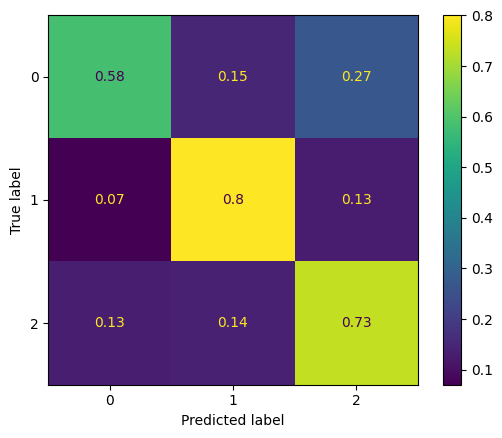

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()